In [ ]:
# Don't forget to restart the runtime afterwards!
!pip install gammapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 712.4/712.4 KB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.9/348.9 KB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 50.7 MB/s eta 0:00:00
  Created wheel for gammapy: filename=gammapy-1.0-cp38-cp38-linux_x86_64.whl size=879989 sha256=e8ba6f34519546e791b1ec3681e2c74df027c64a7c613963b96cf6ede621497d
  Stored in directory: /root/.cache/pip/wh

In [ ]:
# CTA IRFs are officially downloaded from the following link
# The zip contains many IRFs for many different configurations,
# check it out if you are interested to see different ones

# https://zenodo.org/record/5499840/files/cta-prod5-zenodo-fitsonly-v0.1.zip?download=1

# You can find the ones I'll be using on my github
# There are 3 files for the same configurations but different observation times
# Upload them to colab:
# On the left click the folder, then the file with the arrow
# The following command should show them:

In [ ]:
ls

ebl_dominguez11.fits                                         sample_data/
Prod5-South-20deg-AverageAz-14MSTs37SSTs.1800s-v0.1.fits.gz


In [ ]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
import matplotlib.pyplot as plt

In [ ]:
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, EBLAbsorptionNormSpectralModel
from gammapy.maps import MapAxis, RegionGeom
from gammapy.data import Observation, observatory_locations
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets, FluxPointsDataset
from gammapy.makers import SpectrumDatasetMaker
from gammapy.estimators import FluxPointsEstimator
from gammapy.irf import load_cta_irfs

### Task: GRB Simulation

#### Simple
- (If you want, pick your own time-dependent GRB spectrum)
- Pick the width of your time bins and choose the appropriate IRF for your choice
- Adapt parameters of your spectrum and time dependence
- Plot excess counts (or excess count rate) vs time (light curve with counts)
- Plot the spectrum for each time bin
- What's the smallest observation time binning you can choose to get 5 bins in the light curve with > 3 sigma significance (sqrt_TS)?


In [ ]:
# Select your time bins
# (To reduce computation time, you might not want to choose too many bins)
Ts = np.linspace(0.001, #?#, 5) * ## Time unit##

In [ ]:
# Select an appropriate IRF that fits your intended time bin width
# Note that CTA is a pointed telescope and observation time is limited
irfs = load_cta_irfs('Prod5-South-20deg-AverageAz-14MSTs37SSTs.##???##s-v0.1.fits.gz')

In [ ]:
name = 'Transient Simulation'

# Choose arbitrary pointing for this simulation
pointing = SkyCoord(0, 0, unit='deg', frame='galactic')

# Related to angular resolution and extension
# (Extragalactic sources are point sources)
on_region_radius = Angle('0.11 deg')

models = {'T':[], 'model':[]}

# Assume the below is the spectrum at T=0
# The flux of the GRB will decrease over time after the explosion
# Assume some temporal relationship, such as a powerlaw ~ T^-1.2 for the decay

for i, T in enumerate(Ts):
    models['T'].append(T)
    ampl = 1e-9 * T.to(u.h).value ** ##?##

    # Define GRB source spectrum
    # Note: Something seems wrong / inconsistent with the spectrum normalisation
    # - much higher than in previous versions - in the new (finally v1!!) version
    # I adapted the amplitude accordingly
    spectral_model = PowerLawSpectralModel(
        index=2.4,
        amplitude=f"{ampl} cm-2 s-1 GeV-1",
        reference=10 * u.GeV,
    )

    # Define EBL absorption according to redshift
    # Note: CTA might be able to see up to redshift 4
    # Current instruments are able to see redshift ~ 1
    spectral_model *= EBLAbsorptionNormSpectralModel.read(
        'ebl_dominguez11.fits', 
        redshift=0.4
    )

    models['model'].append(SkyModel(spectral_model=spectral_model, name=name))

In [ ]:
# Define simulation parameters

# Choose observation time you want to simulate
# The IRF you loaded before should be in the same range (seconds / minutes / hours)
# If not, reload different IRF
livetime = ##?## * ## time unit ##

# This is how far away from our source we point. 
# Performance is dependent on this.
# The larger, the more certain the background estimate
# Should not be larger than camera FoV
offset = 1 * u.deg

# Reconstructed energy axis
# Standard in CTA is 5 bins per decade (related to energy resolution)
energy_axis = MapAxis.from_edges(
    np.logspace(-1, 3, 21), unit="TeV", name="energy", interp="log"
)

# True energy axis
# Should always cover larger range as reconstructed axis on both sides
# Should also have finer binning, 
# for example to properly capture steep changes in effective area
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 4.0, 101), unit="TeV", name="energy_true", interp="log"
)

center = pointing.directional_offset_by(
    position_angle=0*u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

# New Section

In [ ]:
# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, #name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

In [ ]:
fpe = FluxPointsEstimator(energy_edges=energy_axis.edges, 
                          selection_optional='all')

In [ ]:
datasets = Datasets()

location = observatory_locations["cta_south"]
obs = Observation.create(
        pointing=pointing,
        livetime=livetime,
        irfs=irfs,
        location=location,
)
    
for i in range(len(Ts)):
  dataset = maker.run(dataset_empty, obs)

  # Set the model on the dataset, and fake
  dataset.models = models['model'][i]
  dataset.fake(random_state=42)
  # print(dataset)
      
  dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
  dataset=dataset, acceptance=1, acceptance_off=5, name=f'T={models["T"][i]}'
  )
  dataset_on_off.fake(random_state=42, npred_background=dataset.npred_background())
  # print(dataset_on_off)

  datasets.append(dataset_on_off)

In [ ]:
datasets.info_table()

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str10,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
T=0.01 h,43010,42979.6015625,390.07930505480937,30.399999618530273,7193.666755994989,7193.666755994989,nan,3539673.25,1618041344.0,359.99999999999875,359.99999999999875,119.47222222222264,0.08444444338480661,119.38778211805597,20,20,wstat,152279.96661171305,152,20.0,100.0,0.20000000298023224
T=0.2575 h,891,859.0,48.52434635709084,32.0,904.6378356209913,32.03907792989388,872.5987576910975,3539673.19984576,1618041373.286807,359.99999999999875,359.99999999999875,2.4750000000000085,0.0888888888888892,2.3861111111111195,20,20,wstat,8.754150824420442,160,20.0,100.0,0.2
T=0.505 h,414,384.2,29.78638663314575,29.8,418.6458660002498,29.78197569766318,388.8638903025866,3539673.19984576,1618041373.286807,359.99999999999875,359.99999999999875,1.150000000000004,0.08277777777777806,1.0672222222222258,20,20,wstat,10.035214716322072,149,20.0,100.0,0.2
T=0.7525 h,261,229.0,20.844178291499425,32.0,272.8516042405212,31.8946498189756,240.95695442154567,3539673.19984576,1618041373.286807,359.99999999999875,359.99999999999875,0.7250000000000025,0.0888888888888892,0.6361111111111133,20,20,wstat,11.436934119861434,160,20.0,100.0,0.2
T=1.0 h,195,163.0,16.384471592338528,32.0,203.40032824470245,32.104309036092474,171.29601920860998,3539673.19984576,1618041373.286807,359.99999999999875,359.99999999999875,0.5416666666666685,0.0888888888888892,0.45277777777777933,20,20,wstat,13.25268885676302,160,20.0,100.0,0.2


Text(0, 0.5, 'Excess Counts')

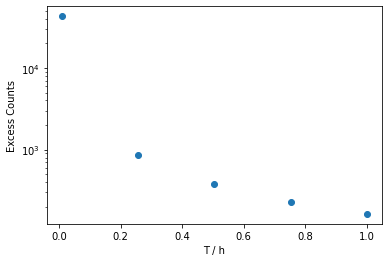

In [ ]:
plt.plot(Ts, datasets.info_table()['excess'], 'o')

plt.yscale('log')

plt.xlabel(f'T / {Ts.unit}')
plt.ylabel('Excess Counts');

In [ ]:
flux_points_datasets = Datasets()

for i, d in enumerate(datasets):
    flux_points = fpe.run(datasets=[d])
    flux_points_datasets.append(
        FluxPointsDataset(data=flux_points, models=models['model'][i], name=d.name))

T=0.01 h
T=0.2575 h
T=0.505 h
T=0.7525 h
T=1.0 h


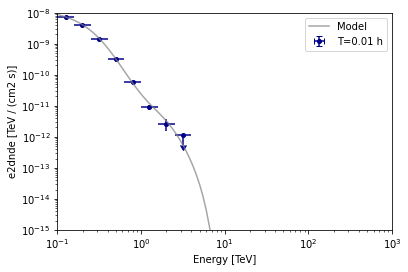

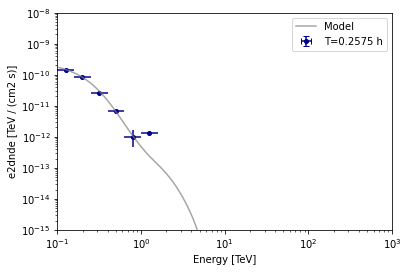

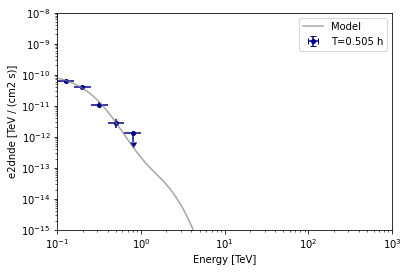

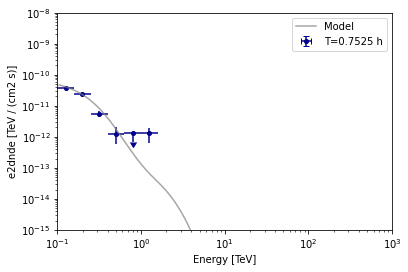

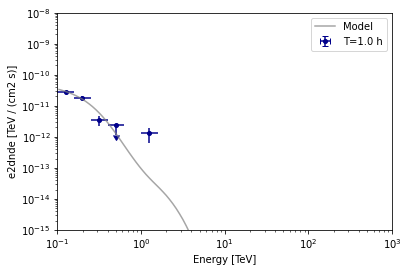

In [ ]:
ax = plt.subplot()
ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for i, d in enumerate(flux_points_datasets):
    ax = plt.subplot()
    ax.yaxis.set_units(u.Unit("TeV cm-2 s-1"))
    kwargs = {"ax": ax, "sed_type": "e2dnde"}
        
    d.plot_spectrum(kwargs_fp = {'label': d.name, 'color':'darkblue'}, 
                    kwargs_model = {'label':'Model', 'color':'gray', 'alpha': 0.7})

    ax.legend(loc='upper right')
    ax.set_ylim(1e-15, 1e-8)
    plt.show()

### Task: GRB Simulation

#### Advanced
- Plot lightcurve with flux of some energy bin
- In the same plot, plot lightcurve with flux of different energy bin
- In a new plot, plot lightcurve integrated flux
- Compare spectra for different EBL models (interesting for the super bright GRB)